In [1]:
library(tidyverse)
library(magrittr)
library(here)
library(furrr)

devtools::load_all(".")

plan(multiprocess)

options(future.globals.maxSize= 1500*1024^2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.0
✔ tibble  2.1.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

here() starts at /mnt/expressions/mp/ychr
Loading required package: future
Loading ychr
Warning message:
“no function found corresponding to methods exports from ‘GenomicRanges’ for: ‘concatenateObjects’”

# Lineage assignment (Mez2 vs A00 vs chimp)

In [2]:
df <- read_genotypes("mez2", "full", mindp = 3, maxdp = 0.975, tv_only = TRUE) %>%
    select(chrom, pos, REF, ALT, mez2, chimp, a00) %>%
    filter(complete.cases(.))

In [3]:
head(df)

chrom,pos,REF,ALT,mez2,chimp,a00
Y,2649827,G,,0,0,0
Y,2649828,T,,0,0,0
Y,2649829,T,,0,0,0
Y,2649830,A,,0,0,0
Y,2649831,A,,0,0,0
Y,2649832,T,,0,0,0


In [4]:
nrow(df)

[1] 4562757

In [107]:
props %<-% future_map_dfr(c("den4", "den8", "spy1", "elsidron2", "shotgun_spy1", "shotgun_mez2"), function(arch) {
    capture <- ifelse(arch == "elsidron2", "lippold", "full")

    arch_df <- read_vcf(here(paste0("data/vcf/", capture, "_", arch, ".vcf.gz")), mindp = 3, maxdp = 0.975)
    joined <- inner_join(df, arch_df, by = c("chrom", "pos", "REF")) %>% filter(ALT.y == "" | ALT.x == ALT.y)

    joined <- filter(joined, complete.cases(joined))

    tibble(
        hum   = sum(joined[["mez2"]] == joined[["chimp"]] & joined[["a00"]] != joined[["mez2"]]  & joined[[arch]] == joined[["a00"]]),
        neand = sum(joined[["a00"]]  == joined[["chimp"]] & joined[["a00"]] != joined[["mez2"]]  & joined[[arch]] == joined[["mez2"]]),
        anc   = sum(joined[["mez2"]] == joined[["a00"]]   & joined[["a00"]] != joined[["chimp"]] & joined[[arch]] == joined[["chimp"]]),
        total = hum + neand + anc
    ) %>%
        gather(lineage, count, -total) %>%
        mutate(name = arch, prop = count / total) %>%
        select(name, everything())
})

In [151]:
props %>% select(-prop) %>% spread(lineage, count)

name,total,anc,hum,neand
den4,114,112,1,1
den8,358,342,6,10
elsidron2,27,0,0,27
shotgun_mez2,34,0,0,34
shotgun_spy1,10,0,0,10
spy1,19,0,1,18


In [7]:
props %>% select(-count) %>% spread(lineage, prop)

name,total,anc,hum,neand
den4,114,0.9824561,0.00877193,0.00877193
den8,358,0.9553073,0.01675978,0.02793296
elsidron2,27,0.0000000,0.00000000,1.00000000
shotgun_mez2,34,0.0000000,0.00000000,1.00000000
shotgun_spy1,10,0.0000000,0.00000000,1.00000000
spy1,19,0.0000000,0.05263158,0.94736842


Both Denisovan Y chromosomes fall with close to 100% certainty to a branch ancestral to AMH and Neanderthals.

The small number of sites falling on human or Neanderthal branches is easily explained by DNA damage - a truly ancestral site carrying a damage substitution will flip with 50% probability to one or the other, which is what we see for both Denisova 4 and Denisova 8.

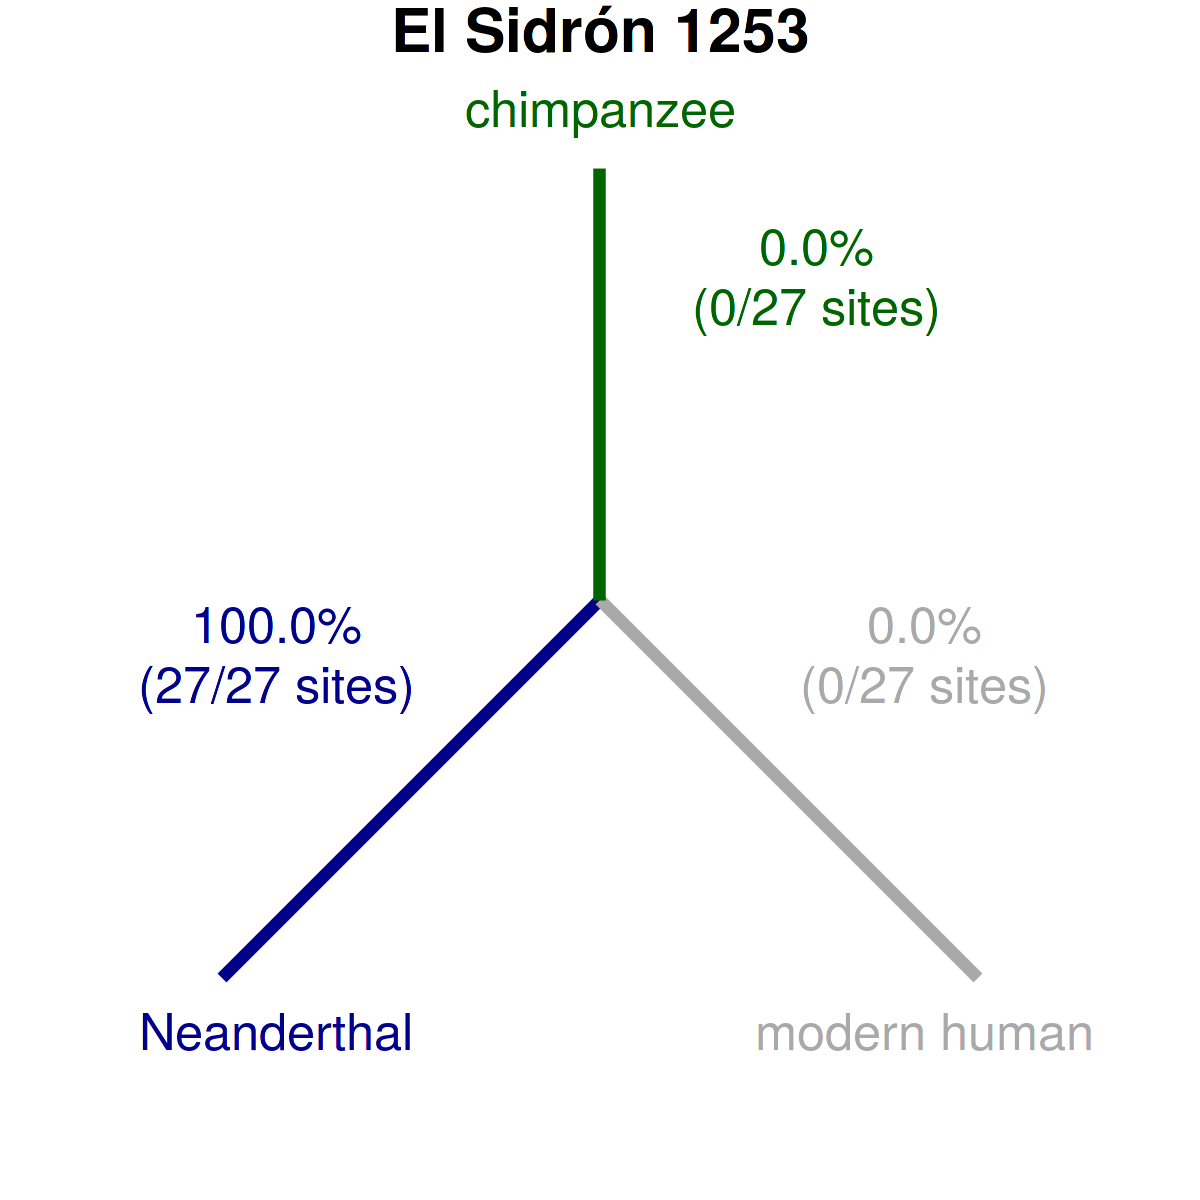

In [230]:
set_dim(4, 4)

plot_lineages <- function(df, archaic) {
    par(mar = c(1, 1, 1, 1))

    stopifnot(archaic %in% df$name)

    name <- case_when(
        archaic == "den8" ~ "Denisova 8",
        archaic == "den4" ~ "Denisova 4",
        archaic == "spy1" ~ "Spy 1",
        archaic == "mez2" ~ "Mezmaiskaya 2",
        archaic == "elsidron2" ~ "El Sidrón 1253",
        archaic == "shotgun_spy1" ~ "Spy 1 (shotgun)",
        archaic == "shotgun_mez2" ~ "Mazmaiskaya 2 (shotgun)"
    )

    anc <- filter(df, name == archaic, lineage == "anc")$prop
    hum <- filter(df, name == archaic, lineage == "hum")$prop
    neand <- filter(df, name == archaic, lineage == "neand")$prop

    count_anc <- filter(df, name == archaic, lineage == "anc")$count
    count_hum <- filter(df, name == archaic, lineage == "hum")$count
    count_neand <- filter(df, name == archaic, lineage == "neand")$count

    total <- filter(df, name == archaic)$total[1]

    plot(0, main = name, axes = FALSE, xaxs="i", yaxs="i", type = "n", xlab = "", ylab = "", xlim = c(0, 10), ylim = c(0, 10))

    segments(x0 = 1.5, x1 = 5, y0 = 1.5, y1 = 5, col = "darkblue", lend = "butt", lwd = 3)
    segments(x0 = 8.5, x1 = 5, y0 = 1.5, y1 = 5, col = "darkgray", lend = "butt", lwd = 3)
    segments(x0 = 5, x1 = 5, y0 = 5, y1 = 9, col = "darkgreen", lend = "butt", lwd = 3)

    text(5, 9.5, "chimpanzee", col = "darkgreen")
    text(7, 8, sprintf("%.1f%%\n(%d/%d sites)", anc * 100, count_anc, total), col = "darkgreen")

    text(2, 1, "Neanderthal", col = "darkblue")
    text(2, 4.5, sprintf("%.1f%%\n(%d/%d sites)", neand * 100, count_neand, total), col = "darkblue")

    text(8, 1, "modern human", col = "darkgray")
    text(8, 4.5, sprintf("%.1f%%\n(%d/%d sites)", hum * 100, count_hum, total), col = "darkgray")
}

plot_lineages(props, "elsidron2")

# Estimating high-coverage Mez2-AMH divergence time

In [9]:
calculate_direct <- function(archaic, capture, mindp) {
    gt <- read_genotypes(archaic, capture, mindp = mindp, maxdp = 0.975, tv_only = TRUE) %>% filter(complete.cases(.))

    tafr <- calculate_tafr(gt, "a00") %>% summarise_if(is.numeric, mean)
    
    tibble(
        name = archaic,
        arch = sum(gt$a00 == gt$chimp & gt[[archaic]] != gt$chimp),
        hum = sum(gt[[archaic]] == gt$chimp & gt$a00 != gt$chimp),
        anc = sum(gt[[archaic]] == gt$a00 & gt$a00 != gt$chimp),
        total = nrow(gt),
        mut_rate = tafr$mut_rate,
        tmrca = hum / (total * mut_rate),
        dp = mindp
     )
}

In [10]:
direct_tmrca <- future_map_dfr(1:10, function(i) calculate_direct("mez2", "full", i))

In [11]:
direct_tmrca %>% mutate(arch / hum, anc / hum)

name,arch,hum,anc,total,mut_rate,tmrca,dp,arch/hum,anc/hum
mez2,376,448,70059,2716694,4.549270e-10,362489.6,1,0.8392857,156.3817
mez2,308,436,69148,2677201,4.571684e-10,356229.1,2,0.7064220,158.5963
mez2,291,430,68216,2634792,4.457122e-10,366157.2,3,0.6767442,158.6419
mez2,272,416,67079,2584015,4.438862e-10,362682.6,4,0.6538462,161.2476
mez2,259,403,65347,2510825,4.432091e-10,362142.9,5,0.6426799,162.1514
mez2,239,383,62815,2408787,4.406942e-10,360797.1,6,0.6240209,164.0078
mez2,215,360,58892,2262688,4.283537e-10,371428.6,7,0.5972222,163.5889
mez2,183,322,52921,2049838,4.227976e-10,371538.5,8,0.5683230,164.3509
mez2,134,266,44546,1749331,4.280024e-10,355274.0,9,0.5037594,167.4662
mez2,91,197,34186,1368345,4.122517e-10,349227.3,10,0.4619289,173.5330


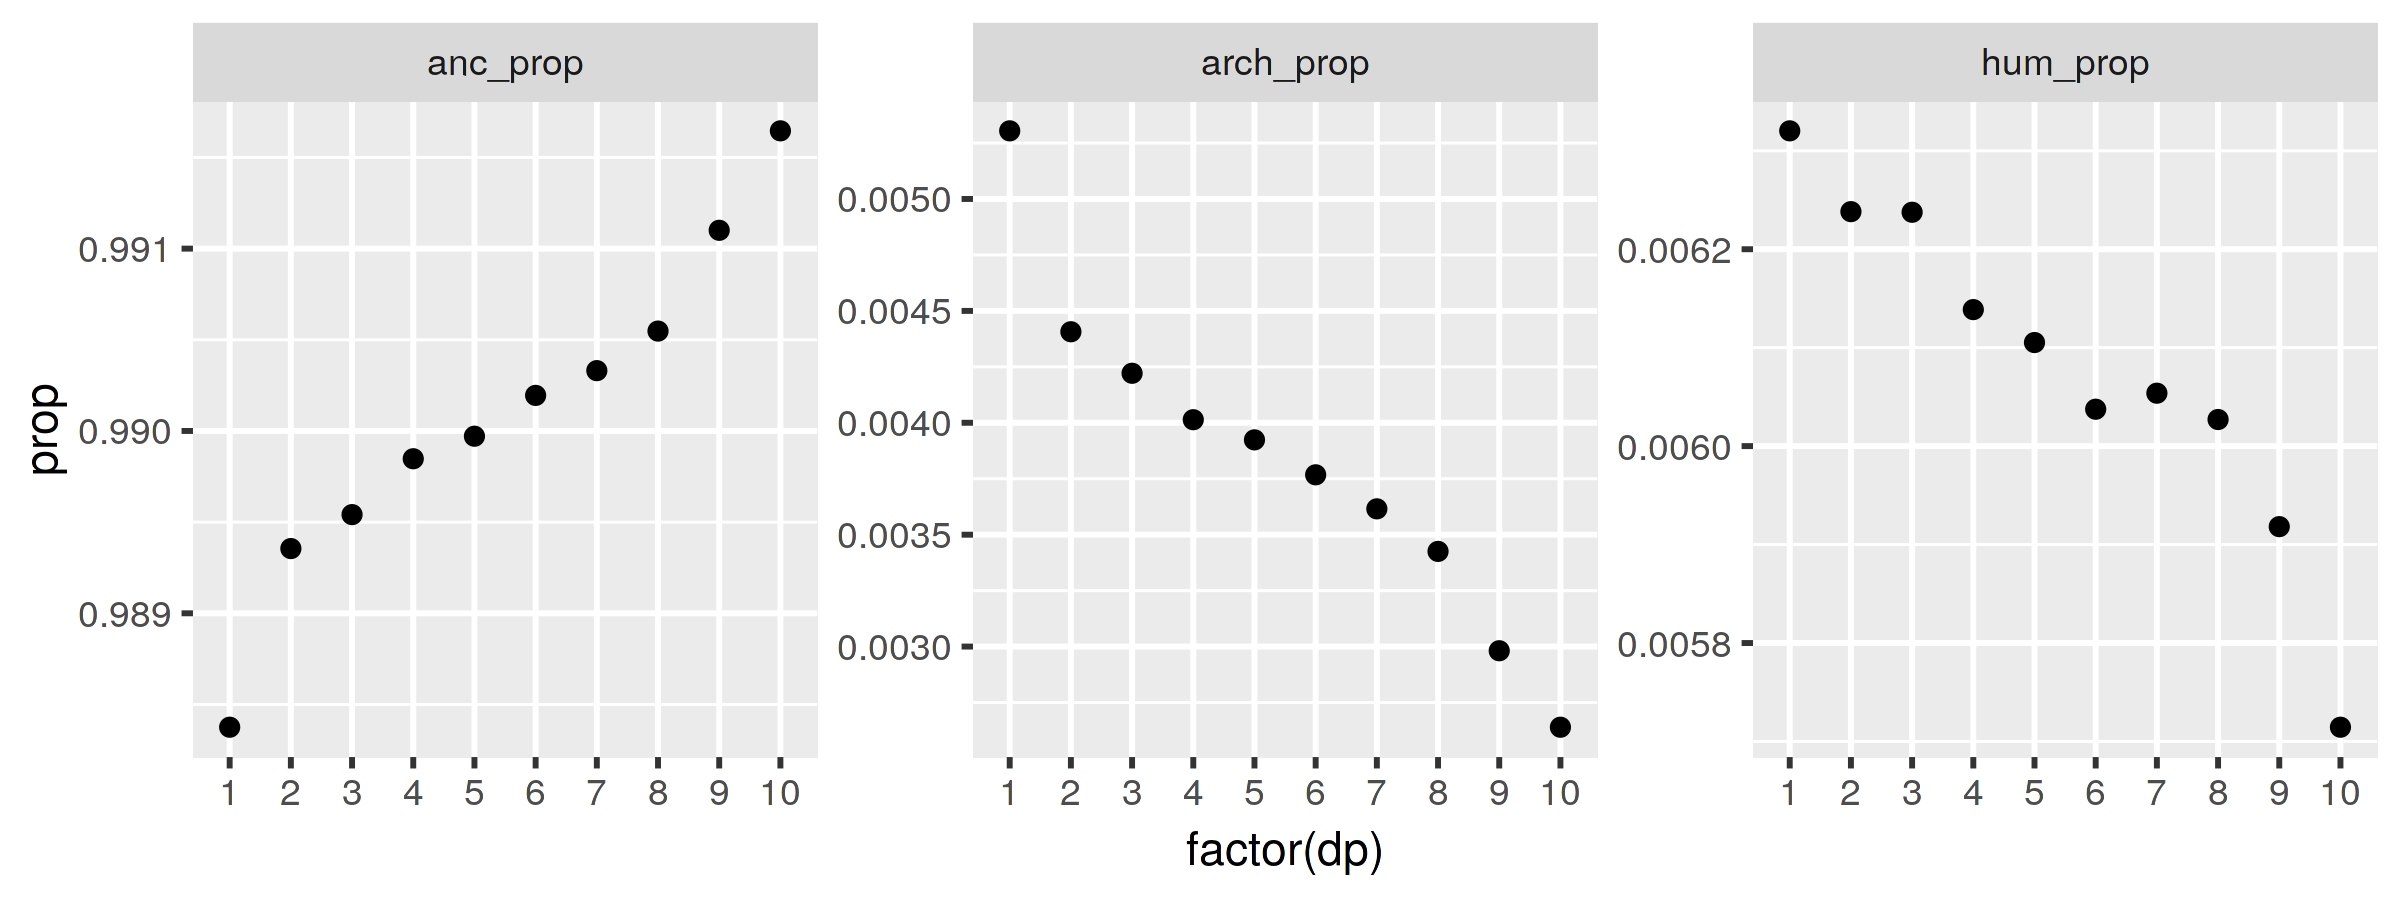

In [14]:
set_dim(8, 3)

direct_tmrca %>%
mutate(n = arch + hum + anc, arch_prop = arch / n, hum_prop = hum / n, anc_prop = anc / n) %>%
select(name, dp, arch_prop, hum_prop, anc_prop) %>%
gather(branch, prop, -name, -dp) %>%
ggplot(aes(factor(dp), prop)) + geom_point() + facet_wrap(~ branch, scales = "free")

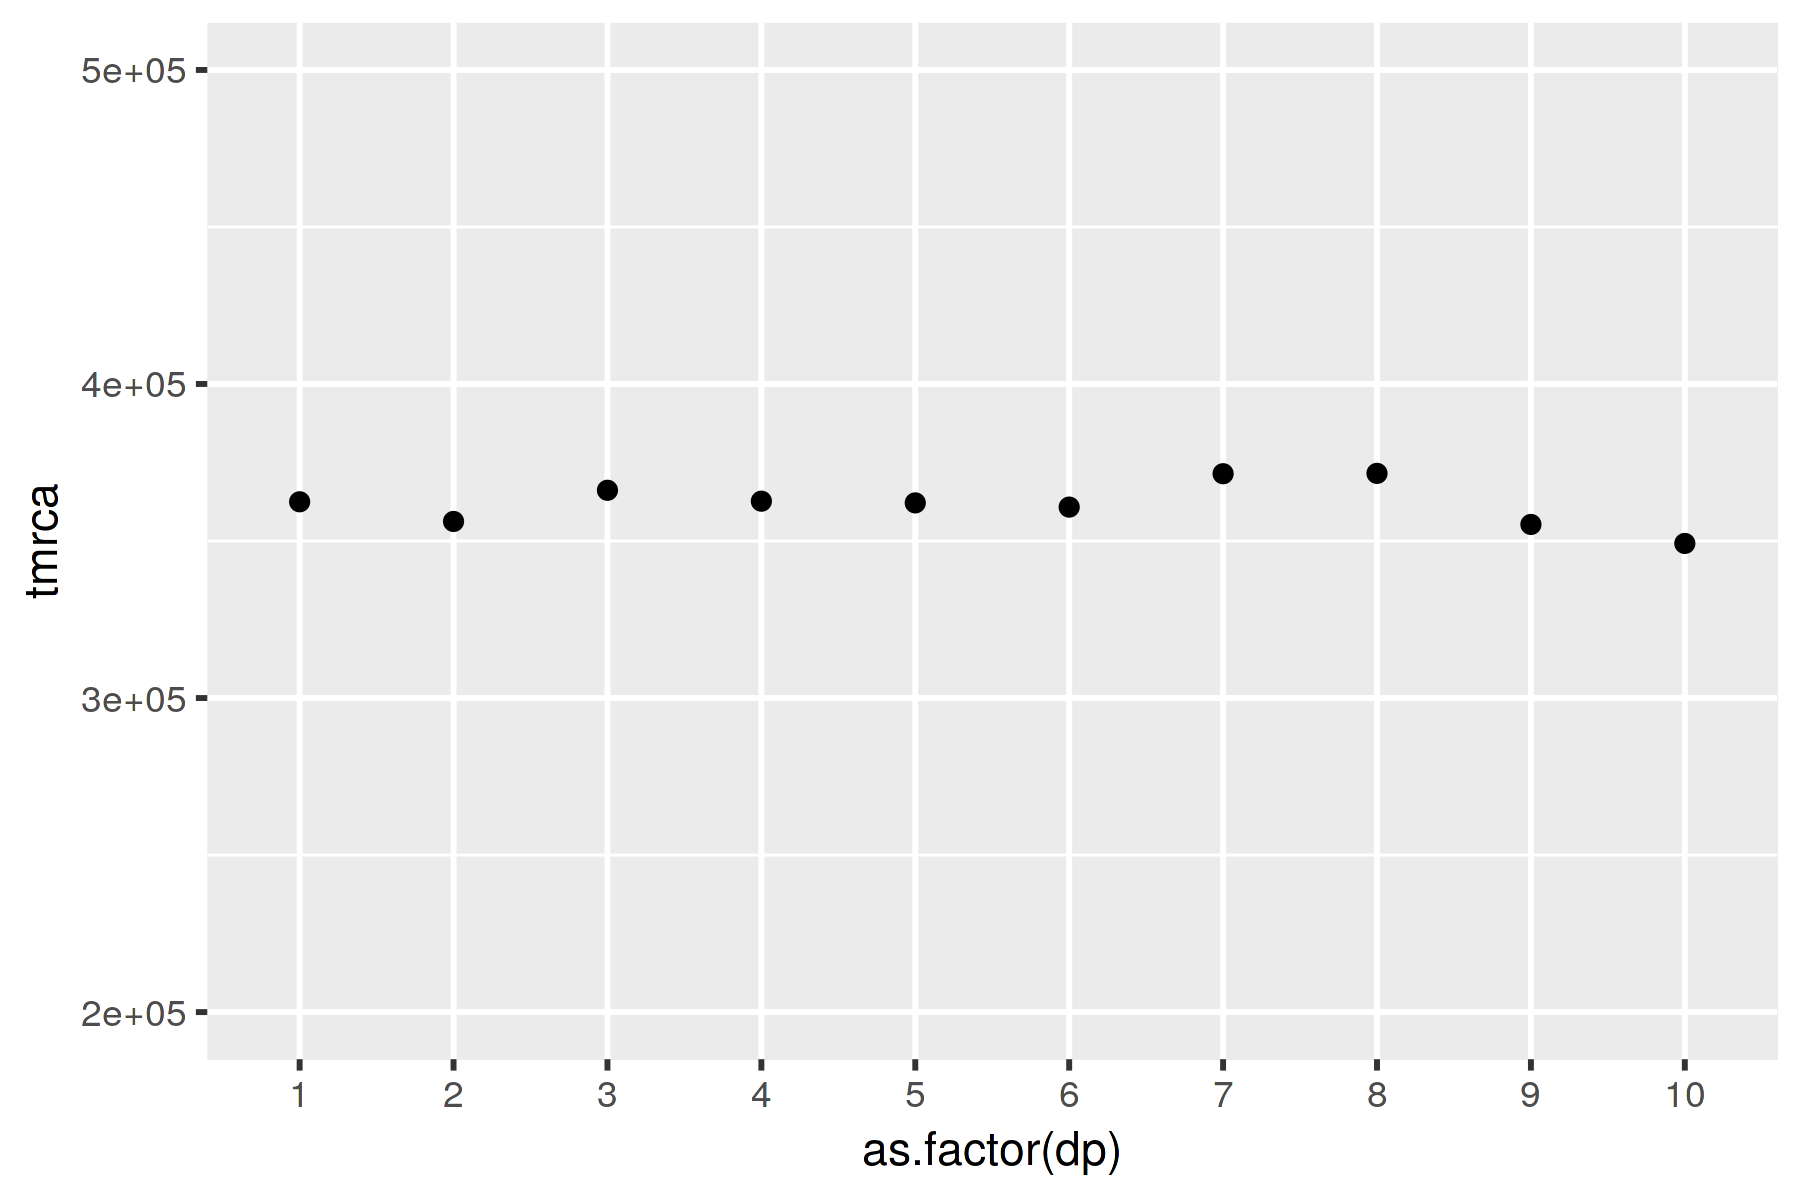

In [15]:
set_dim(6, 4)

ggplot(direct_tmrca, aes(as.factor(dp), tmrca)) + geom_point() + ylim(200000, 500000)